# NYC Taxi Demand vs Used Car Price Analysis (Hybrid: Laptop/Cloud)
## Hypothesis: Taxi demand correlates with used car prices in New York areas

This notebook analyzes the correlation between NYC taxi trip density (2019-2020) and Craigslist used car prices in NY regions.

**Deployment Mode**: Toggle `LAPTOP_DEPLOYMENT` flag below to switch between:
- `True`: Pandas-only (Mac laptop friendly, < 16GB RAM recommended)
- `False`: Spark + Pandas (Cloudera AI / cluster deployment)

## 🔧 DEPLOYMENT CONFIGURATION

In [11]:
# ============================================================================
# TOGGLE THIS FLAG TO SWITCH DEPLOYMENT MODES
# ============================================================================


LAPTOP_DEPLOYMENT = True  # Set to False for Spark/Cloud deployment
# ============================================================================


In [12]:

print(f"\n{'='*60}")
print(f"  DEPLOYMENT MODE: {'LAPTOP (Pandas)' if LAPTOP_DEPLOYMENT else 'CLOUD (Spark)'}")
print(f"{'='*60}\n")

if LAPTOP_DEPLOYMENT:
    print("✓ Running in Laptop mode (Pandas-only)")
    print("  - No Spark required")
    print("  - Lighter memory footprint")
    print("  - Good for datasets < 10GB")
else:
    print("✓ Running in Cloud mode (Spark + Pandas)")
    print("  - Distributed processing enabled")
    print("  - Scalable for large datasets")
    print("  - Optimized for Cloudera AI")


  DEPLOYMENT MODE: LAPTOP (Pandas)

✓ Running in Laptop mode (Pandas-only)
  - No Spark required
  - Lighter memory footprint
  - Good for datasets < 10GB


## 1. Setup and Package Installation

**💡 Recommended Alternative:** Use `uv sync` before opening the notebook for faster, reproducible installs!

```bash
# Laptop mode: uv sync --extra laptop --extra dev
# Cloud mode:  uv sync --extra cloud --extra dev
# See UV_SETUP.md for details
```

If you've already run `uv sync`, you can **skip this cell** entirely!

In [ ]:
# ============================================================================
# INSTALLATION METHOD: Choose pip or uv
# ============================================================================
USE_UV = False  # Set to True to use uv (faster), False for pip
# ============================================================================

import sys

if USE_UV:
    # Using uv (faster package installer)
    # Install uv first if not already installed: curl -LsSf https://astral.sh/uv/install.sh | sh
    print("📦 Installing packages with uv (fast mode)...")
    
    if LAPTOP_DEPLOYMENT:
        # Laptop mode packages
        !uv pip install --system kaggle pandas numpy matplotlib seaborn plotly pyarrow fastparquet
    else:
        # Cloud mode packages
        !uv pip install --system kaggle opendatasets pandas numpy matplotlib seaborn plotly
else:
    # Using standard pip
    print("📦 Installing packages with pip...")
    
    if LAPTOP_DEPLOYMENT:
        # Laptop mode packages
        !pip install kaggle pandas numpy matplotlib seaborn plotly pyarrow fastparquet -q
    else:
        # Cloud mode packages
        !pip install kaggle opendatasets pandas numpy matplotlib seaborn plotly -q

print("✓ Packages installed successfully!")

## 2. Import Libraries and Initialize

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

if LAPTOP_DEPLOYMENT:
    # Laptop mode: Pandas only
    print("Initializing Pandas environment...")
    # Optimize pandas for larger datasets
    pd.options.mode.chained_assignment = None
    print(f"✓ Pandas version: {pd.__version__}")
else:
    # Cloud mode: Import and initialize Spark
    print("Initializing Spark environment...")
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    from pyspark.sql.window import Window
    
    spark = SparkSession.builder \
        .appName("TaxiCarPriceCorrelation") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()
    
    print(f"✓ Spark version: {spark.version}")
    print(f"✓ Pandas version: {pd.__version__}")

Initializing Pandas environment...
✓ Pandas version: 2.3.3


## 3. Download Datasets

**Note**: You need Kaggle API credentials:
1. Go to Kaggle → Account → Create New API Token
2. Place `kaggle.json` in `~/.kaggle/` directory
3. Run: `chmod 600 ~/.kaggle/kaggle.json`

In [3]:
# Create data directory
os.makedirs('data', exist_ok=True)

# Download Craigslist cars dataset
print("Downloading Craigslist cars dataset...")
!kaggle datasets download -d austinreese/craigslist-carstrucks-data -p ./data --unzip

# Download NYC taxi dataset
print("\nDownloading NYC Yellow Taxi dataset...")
!kaggle datasets download -d microize/newyork-yellow-taxi-trip-data-2020-2019 -p ./data --unzip

print("\n✓ Download complete!")
!ls -lh data/

Dataset URL: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
License(s): CC0-1.0
 78%|███████████████████████████████         | 204M/262M [00:00<00:00, 2.14GB/s]
100%|████████████████████████████████████████| 262M/262M [00:00<00:00, 2.13GB/s]

Dataset URL: https://www.kaggle.com/datasets/microize/newyork-yellow-taxi-trip-data-2020-2019
License(s): ODbL-1.0
 99%|█████████████████████████████████████▌| 1.78G/1.81G [00:01<00:00, 2.01GB/s]
100%|██████████████████████████████████████| 1.81G/1.81G [00:01<00:00, 1.89GB/s]

✓ Download complete!
total 21200424
-rw-r--r--@ 1 eriksteinholz  staff    12K Feb  2 15:06 taxi+_zone_lookup.csv
drwxr-xr-x@ 9 eriksteinholz  staff   288B Feb  2 15:06 taxi_zones
-rw-r--r--@ 1 eriksteinholz  staff   1.3G Feb  2 15:03 vehicles.csv
-rw-r--r--@ 1 eriksteinholz  staff   655M Feb  2 15:06 yellow_tripdata_2019-01.csv
-rw-r--r--@ 1 eriksteinholz  staff   620M Feb  2 15:06 yellow_tripdata_2019-02.csv
-rw-r--r--@ 1 eriksteinholz  staff   693M 

## 4. Load Data

In [14]:
print("Loading Craigslist dataset...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Use Pandas with optimized dtypes
    craigslist_df = pd.read_csv(
        "data/vehicles.csv",
        low_memory=False
    )
    print(f"✓ Loaded {len(craigslist_df):,} records")
    print(f"\nColumns: {list(craigslist_df.columns)}")
    print(f"\nSample data:")
    print(craigslist_df.head())
else:
    # Cloud: Use Spark
    craigslist_df = spark.read.csv(
        "data/vehicles.csv",
        header=True,
        inferSchema=True
    )
    print("Craigslist Dataset Schema:")
    craigslist_df.printSchema()
    print(f"\n✓ Total records: {craigslist_df.count():,}")
    print("\nSample data:")
    craigslist_df.show(5, truncate=False)

Loading Craigslist dataset...
✓ Loaded 426,880 records

Columns: ['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']

Sample data:
           id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN  

In [15]:
# Check available states
print("States in Craigslist dataset:")

if LAPTOP_DEPLOYMENT:
    state_counts = craigslist_df['state'].value_counts().head(10)
    print(state_counts)
else:
    craigslist_df.groupBy("state").count().orderBy(desc("count")).show(10)

States in Craigslist dataset:
state
ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
Name: count, dtype: int64


## 4.5 Explore Craigslist Data: Ranges and Distributions

Comprehensive exploration of the Craigslist dataset to understand data quality, ranges, and distributions.

**Note:** Taxi data exploration will occur after taxi data is loaded (Section 4.6).

In [17]:
print("="*80)
print("CRAIGSLIST DATASET EXPLORATION")
print("="*80)
print("⚠️  Note: For large Spark datasets, some operations use sampling to avoid memory/shuffle issues")
print("")

if LAPTOP_DEPLOYMENT:
    # Pandas exploration
    df = craigslist_df
    
    print(f"\n{'='*80}")
    print("1. DATASET OVERVIEW")
    print(f"{'='*80}")
    print(f"Total records: {len(df):,}")
    print(f"Total columns: {len(df.columns)}")
    print(f"\nColumns: {', '.join(df.columns)}")
    
    print(f"\n{'='*80}")
    print("2. DATA TYPES AND MISSING VALUES")
    print(f"{'='*80}")
    info_df = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null %': (df.isnull().sum() / len(df) * 100).round(2)
    })
    print(info_df.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("3. NUMERIC FIELDS - RANGES AND DISTRIBUTIONS")
    print(f"{'='*80}")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            print(f"\n{col.upper()}:")
            print(f"  Count: {df[col].notna().sum():,}")
            print(f"  Min: {df[col].min():,.2f}")
            print(f"  25th percentile: {df[col].quantile(0.25):,.2f}")
            print(f"  Median (50th): {df[col].median():,.2f}")
            print(f"  Mean: {df[col].mean():,.2f}")
            print(f"  75th percentile: {df[col].quantile(0.75):,.2f}")
            print(f"  Max: {df[col].max():,.2f}")
            print(f"  Std Dev: {df[col].std():,.2f}")
            print(f"  Range: {df[col].max() - df[col].min():,.2f}")
    
    print(f"\n{'='*80}")
    print("4. CATEGORICAL FIELDS - VALUE COUNTS")
    print(f"{'='*80}")
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols[:10]:  # Limit to first 10 to avoid too much output
        if df[col].notna().sum() > 0:
            n_unique = df[col].nunique()
            print(f"\n{col.upper()} ({n_unique:,} unique values):")
            if n_unique <= 20:  # Show full distribution if few values
                value_counts = df[col].value_counts().head(20)
                for val, count in value_counts.items():
                    pct = (count / len(df) * 100)
                    print(f"  {val}: {count:,} ({pct:.1f}%)")
            else:  # Show top 10 for many values
                value_counts = df[col].value_counts().head(10)
                print(f"  Top 10 values:")
                for val, count in value_counts.items():
                    pct = (count / len(df) * 100)
                    print(f"    {val}: {count:,} ({pct:.1f}%)")
    
    print(f"\n{'='*80}")
    print("5. KEY FIELD: PRICE DISTRIBUTION")
    print(f"{'='*80}")
    if 'price' in df.columns:
        price_valid = df[df['price'].notna() & (df['price'] > 0)]
        print(f"Valid prices (> 0): {len(price_valid):,} ({len(price_valid)/len(df)*100:.1f}%)")
        print(f"\nPrice percentiles:")
        for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
            print(f"  {p}th: ${price_valid['price'].quantile(p/100):,.0f}")
    
    print(f"\n{'='*80}")
    print("6. KEY FIELD: YEAR DISTRIBUTION")
    print(f"{'='*80}")
    if 'year' in df.columns:
        year_valid = df[df['year'].notna()]
        print(f"Valid years: {len(year_valid):,} ({len(year_valid)/len(df)*100:.1f}%)")
        print(f"Year range: {year_valid['year'].min():.0f} - {year_valid['year'].max():.0f}")
        print(f"\nYear distribution (top 10):")
        print(year_valid['year'].value_counts().head(10))
    
    print(f"\n{'='*80}")
    print("7. GEOGRAPHIC DISTRIBUTION")
    print(f"{'='*80}")
    if 'state' in df.columns:
        print("Top 15 states by listing count:")
        print(df['state'].value_counts().head(15))

else:
    # Spark exploration - with error handling for shuffle/memory issues
    from pyspark.sql.functions import col, count, when, isnan, avg, stddev, min as spark_min, max as spark_max, percentile_approx
    
    df = craigslist_df
    
    # Cache to reduce recomputation
    print("Caching dataset for exploration...")
    df.cache()
    
    print(f"\n{'='*80}")
    print("1. DATASET OVERVIEW")
    print(f"{'='*80}")
    try:
        total_records = df.count()
        print(f"Total records: {total_records:,}")
    except Exception as e:
        print(f"⚠️  Could not count records: {type(e).__name__}")
        print("Large dataset - using sample for exploration")
        total_records = None
    
    print(f"Total columns: {len(df.columns)}")
    print(f"\nColumns: {', '.join(df.columns)}")
    
    print(f"\n{'='*80}")
    print("2. SCHEMA AND DATA TYPES")
    print(f"{'='*80}")
    df.printSchema()
    
    print(f"\n{'='*80}")
    print("3. NULL/MISSING VALUE ANALYSIS")
    print(f"{'='*80}")
    try:
        if total_records is None:
            total_count = df.count()
        else:
            total_count = total_records
            
        null_counts = df.select([
            count(when(col(c).isNull(), c)).alias(c) 
            for c in df.columns
        ]).collect()[0].asDict()
        
        print(f"{'Column':<25} {'Null Count':<15} {'Null %':<10}")
        print("-" * 50)
        for column in df.columns:
            null_count = null_counts[column]
            null_pct = (null_count / total_count * 100)
            print(f"{column:<25} {null_count:<15,} {null_pct:<10.2f}")
    except Exception as e:
        print(f"⚠️  Null analysis failed: {type(e).__name__}")
        print("Skipping detailed null analysis")
    
    print(f"\n{'='*80}")
    print("4. NUMERIC FIELDS - SUMMARY STATISTICS")
    print(f"{'='*80}")
    numeric_cols = [field.name for field in df.schema.fields 
                   if str(field.dataType) in ['IntegerType', 'LongType', 'FloatType', 'DoubleType']]
    
    if numeric_cols:
        try:
            df.select(numeric_cols).summary("count", "mean", "stddev", "min", "50%", "max").show(truncate=False)
        except Exception as e:
            print(f"⚠️  Summary statistics failed: {type(e).__name__}")
            print("Trying with sample...")
            try:
                df_sample = df.select(numeric_cols).sample(fraction=0.1).toPandas()
                print(df_sample.describe())
            except:
                print("⚠️  Could not generate statistics. Use LAPTOP_DEPLOYMENT=True instead.")
    
    print(f"\n{'='*80}")
    print("5. CATEGORICAL FIELDS - VALUE COUNTS (Using Sample to Avoid Shuffle Issues)")
    print(f"{'='*80}")
    print("ℹ️  Converting 10% sample to Pandas for robust aggregation\n")
    
    try:
        # Sample and convert to pandas to avoid Spark shuffle issues
        df_sample = df.sample(fraction=0.1, seed=42).toPandas()
        
        categorical_cols = ['state', 'manufacturer', 'type', 'condition', 'fuel', 'transmission']
        for col_name in categorical_cols:
            if col_name in df_sample.columns and df_sample[col_name].notna().sum() > 0:
                print(f"\n{col_name.upper()} distribution (top 10 from 10% sample):")
                value_counts = df_sample[col_name].value_counts().head(10)
                for val, count in value_counts.items():
                    estimated_total = count * 10  # Rough estimate
                    print(f"  {val}: ~{estimated_total:,} (sample: {count:,})")
    except Exception as e:
        print(f"⚠️  Could not generate value counts: {type(e).__name__}")
        print("This is likely due to Spark shuffle issues with large datasets.")
        print("Recommendation: Use LAPTOP_DEPLOYMENT=True for better data exploration")
    
    print(f"\n{'='*80}")
    print("6. KEY FIELD: PRICE DISTRIBUTION")
    print(f"{'='*80}")
    if 'price' in df.columns:
        try:
            price_stats = df.filter(col('price').isNotNull() & (col('price') > 0)).select(
                count('price').alias('count'),
                spark_min('price').alias('min'),
                percentile_approx('price', 0.25).alias('p25'),
                percentile_approx('price', 0.50).alias('median'),
                percentile_approx('price', 0.75).alias('p75'),
                spark_max('price').alias('max'),
                avg('price').alias('mean'),
                stddev('price').alias('stddev')
            ).collect()[0]
            
            print(f"Valid prices (> 0): {price_stats['count']:,}")
            print(f"Min: ${price_stats['min']:,.0f}")
            print(f"25th percentile: ${price_stats['p25']:,.0f}")
            print(f"Median: ${price_stats['median']:,.0f}")
            print(f"Mean: ${price_stats['mean']:,.0f}")
            print(f"75th percentile: ${price_stats['p75']:,.0f}")
            print(f"Max: ${price_stats['max']:,.0f}")
            print(f"Std Dev: ${price_stats['stddev']:,.0f}")
        except Exception as e:
            print(f"⚠️  Price statistics failed: {type(e).__name__}")
            print("Try using LAPTOP_DEPLOYMENT=True for better exploration")
    
    # Clean up cache
    df.unpersist()

print("\n✓ Craigslist data exploration complete!")
print("\nℹ️  Taxi data exploration will be performed after taxi data is loaded (Section 4.6)")

CRAIGSLIST DATASET EXPLORATION
⚠️  Note: For large Spark datasets, some operations use sampling to avoid memory/shuffle issues


1. DATASET OVERVIEW
Total records: 426,880
Total columns: 26

Columns: id, url, region, region_url, price, year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, VIN, drive, size, type, paint_color, image_url, description, county, state, lat, long, posting_date

2. DATA TYPES AND MISSING VALUES
      Column Data Type  Non-Null Count  Null Count  Null %
          id     int64          426880           0    0.00
         url    object          426880           0    0.00
      region    object          426880           0    0.00
  region_url    object          426880           0    0.00
       price     int64          426880           0    0.00
        year   float64          425675        1205    0.28
manufacturer    object          409234       17646    4.13
       model    object          421603        5277    1.24
   con

### 4.5.1 Craigslist Visual Distributions

Generate quick visualizations for key Craigslist fields to understand distributions visually.

**Note:** Taxi visualizations will be in Section 4.6 after taxi data is loaded.

Generating Craigslist distribution plots...


NameError: name 'taxi_pd' is not defined

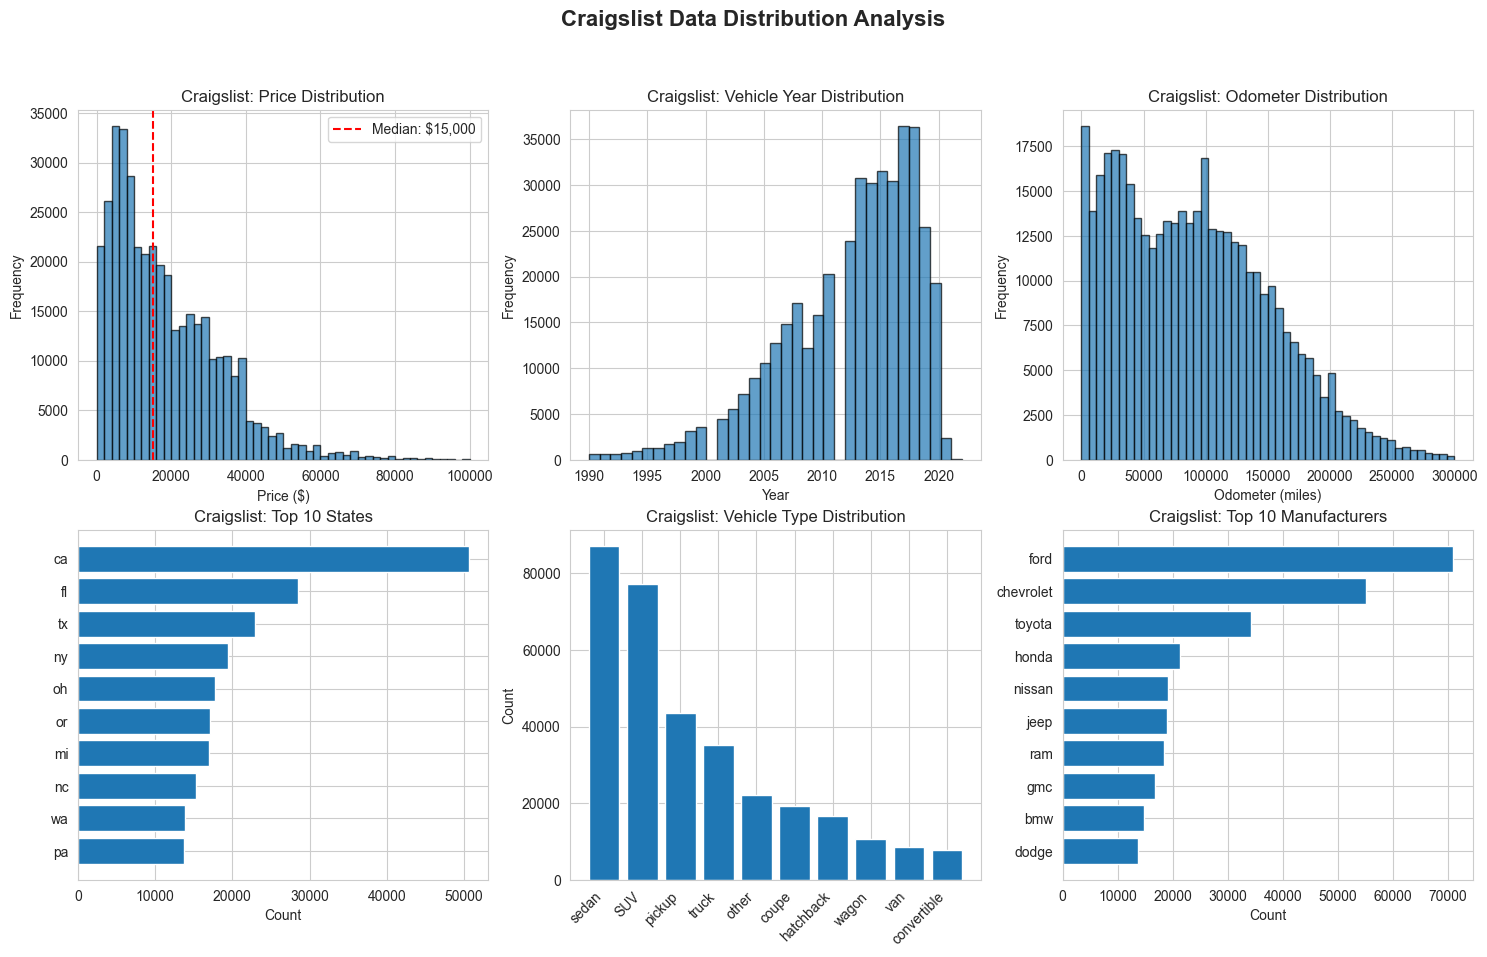

In [18]:
# Craigslist visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("Generating Craigslist distribution plots...")

# Convert to pandas if using Spark
if LAPTOP_DEPLOYMENT:
    cars_pd = craigslist_df
else:
    # Sample for visualization to avoid memory issues
    try:
        print("Sampling Craigslist data for visualization (10%)...")
        cars_pd = craigslist_df.sample(fraction=0.1, seed=42).toPandas()
        print(f"✓ Sampled {len(cars_pd):,} car records")
    except Exception as e:
        print(f"⚠️  Sampling failed: {type(e).__name__}")
        print("Visualization may not be available. Try LAPTOP_DEPLOYMENT=True")
        cars_pd = pd.DataFrame()

# Skip visualization if data is empty
if len(cars_pd) == 0:
    print("⚠️  Cannot generate visualizations - data sampling failed")
    print("\n💡 SOLUTION: Set LAPTOP_DEPLOYMENT=True at the top of the notebook")
    print("This avoids Spark shuffle issues for data exploration")
else:
    # Create subplots (2x3 grid for 6 Craigslist plots)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Craigslist Data Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Price distribution (Craigslist)
if 'price' in cars_pd.columns:
    ax = axes[0, 0]
    price_clean = cars_pd[(cars_pd['price'] > 0) & (cars_pd['price'] < 100000)]
    ax.hist(price_clean['price'], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Price ($)')
    ax.set_ylabel('Frequency')
    ax.set_title('Craigslist: Price Distribution')
    ax.axvline(price_clean['price'].median(), color='red', linestyle='--', label=f'Median: ${price_clean["price"].median():,.0f}')
    ax.legend()

# 2. Year distribution (Craigslist)
if 'year' in cars_pd.columns:
    ax = axes[0, 1]
    year_clean = cars_pd[cars_pd['year'].notna() & (cars_pd['year'] >= 1990)]
    ax.hist(year_clean['year'], bins=35, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Year')
    ax.set_ylabel('Frequency')
    ax.set_title('Craigslist: Vehicle Year Distribution')

# 3. Odometer distribution (Craigslist)
if 'odometer' in cars_pd.columns:
    ax = axes[0, 2]
    odometer_clean = cars_pd[(cars_pd['odometer'] > 0) & (cars_pd['odometer'] < 300000)]
    ax.hist(odometer_clean['odometer'], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Odometer (miles)')
    ax.set_ylabel('Frequency')
    ax.set_title('Craigslist: Odometer Distribution')

# 4. State distribution (Craigslist - top 10)
if 'state' in cars_pd.columns:
    ax = axes[1, 0]
    top_states = cars_pd['state'].value_counts().head(10)
    ax.barh(range(len(top_states)), top_states.values)
    ax.set_yticks(range(len(top_states)))
    ax.set_yticklabels(top_states.index)
    ax.set_xlabel('Count')
    ax.set_title('Craigslist: Top 10 States')
    ax.invert_yaxis()

# 5. Vehicle type distribution (Craigslist)
if 'type' in cars_pd.columns:
    ax = axes[1, 1]
    type_counts = cars_pd['type'].value_counts().head(10)
    ax.bar(range(len(type_counts)), type_counts.values)
    ax.set_xticks(range(len(type_counts)))
    ax.set_xticklabels(type_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title('Craigslist: Vehicle Type Distribution')

# 6. Manufacturer distribution (Craigslist - top 10)
if 'manufacturer' in cars_pd.columns:
    ax = axes[1, 2]
    mfr_counts = cars_pd['manufacturer'].value_counts().head(10)
    ax.barh(range(len(mfr_counts)), mfr_counts.values)
    ax.set_yticks(range(len(mfr_counts)))
    ax.set_yticklabels(mfr_counts.index)
    ax.set_xlabel('Count')
    ax.set_title('Craigslist: Top 10 Manufacturers')
    ax.invert_yaxis()

# 7. Trip distance distribution (Taxi)
trip_dist_cols = [col for col in taxi_pd.columns if 'distance' in col.lower()]
if trip_dist_cols:
    ax = axes[2, 0]
    col_name = trip_dist_cols[0]
    dist_clean = taxi_pd[(taxi_pd[col_name] > 0) & (taxi_pd[col_name] < 50)]
    ax.hist(dist_clean[col_name], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Trip Distance (miles)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Taxi: {col_name} Distribution')
    ax.axvline(dist_clean[col_name].median(), color='red', linestyle='--', label=f'Median: {dist_clean[col_name].median():.2f}')
    ax.legend()
else:
    axes[2, 0].text(0.5, 0.5, 'Trip distance\ncolumn not found', ha='center', va='center', fontsize=12)
    axes[2, 0].axis('off')

# 8. Passenger count distribution (Taxi)
pass_cols = [col for col in taxi_pd.columns if 'passenger' in col.lower()]
if pass_cols:
    ax = axes[2, 1]
    col_name = pass_cols[0]
    pass_counts = taxi_pd[col_name].value_counts().sort_index().head(10)
    ax.bar(pass_counts.index, pass_counts.values)
    ax.set_xlabel('Passenger Count')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Taxi: {col_name} Distribution')
else:
    axes[2, 1].text(0.5, 0.5, 'Passenger count\ncolumn not found', ha='center', va='center', fontsize=12)
    axes[2, 1].axis('off')

# 9. Trip amount distribution (Taxi)
amount_cols = [col for col in taxi_pd.columns if 'amount' in col.lower() or 'fare' in col.lower()]
if amount_cols:
    ax = axes[2, 2]
    col_name = amount_cols[0]
    amount_clean = taxi_pd[(taxi_pd[col_name] > 0) & (taxi_pd[col_name] < 100)]
    ax.hist(amount_clean[col_name], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Amount ($)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Taxi: {col_name} Distribution')
    ax.axvline(amount_clean[col_name].median(), color='red', linestyle='--', label=f'Median: ${amount_clean[col_name].median():.2f}')
    ax.legend()
else:
    axes[2, 2].text(0.5, 0.5, 'Amount/fare\ncolumn not found', ha='center', va='center', fontsize=12)
    axes[2, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print("✓ Distribution plots generated!")
    print("\n📊 Key Observations to Note:")
    print("  - Check for outliers in price, odometer, and trip distance")
    print("  - Verify year distribution aligns with 2019-2020 for analysis")
    print("  - Note dominant states, vehicle types, and manufacturers")
    print("  - Assess data quality from distributions")

### ⚠️ Troubleshooting: If You See Spark Shuffle Errors

**Error:** `Py4JJavaError: Stream is corrupted` or `FetchFailedException`

**Root Cause:** Spark shuffle operations fail with large datasets due to memory pressure or corrupted shuffle files.

**Solutions:**

**Option 1 (Recommended): Use Laptop Mode**
```python
# At the top of the notebook, set:
LAPTOP_DEPLOYMENT = True
```
This uses Pandas instead of Spark and avoids shuffle issues entirely.

**Option 2: Increase Spark Memory**
```python
# Before creating SparkSession, add:
spark = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
```

**Option 3: Skip Exploration Cell**
The exploration cell (section 4.5) is optional. You can skip it and proceed directly to data preparation (section 5).

**Option 4: Use Smaller Sample**
Reduce the sample fraction in visualization cells if errors persist.

In [19]:
print("\nLoading NYC Taxi dataset...")

# Detect file format
taxi_files = !ls data/*.parquet data/*.csv 2>/dev/null || echo "no_files"
is_parquet = any('.parquet' in f for f in taxi_files)

if LAPTOP_DEPLOYMENT:
    # Laptop: Use Pandas with CSV files (avoids parquet issues)
    import glob
    
    # Find CSV files
    csv_files = glob.glob("data/yellow_tripdata_*.csv")
    
    if csv_files:
        print(f"Found {len(csv_files)} CSV files. Loading... (this may take a few minutes)")
        # Load first file to get schema, then load all
        taxi_dfs = []
        for i, csv_file in enumerate(csv_files, 1):
            print(f"  Loading file {i}/{len(csv_files)}: {csv_file.split('/')[-1]}")
            df_chunk = pd.read_csv(csv_file, low_memory=False)
            taxi_dfs.append(df_chunk)
        
        taxi_df = pd.concat(taxi_dfs, ignore_index=True)
        print(f"\n✓ Loaded {len(taxi_df):,} total records from {len(csv_files)} files")
    else:
        print("⚠️  No CSV files found. Check data directory.")
        taxi_df = pd.DataFrame()  # Empty dataframe
    
    if len(taxi_df) > 0:
        print(f"\nColumns: {list(taxi_df.columns)}")
        print(f"\nSample data:")
        print(taxi_df.head())
        
else:
    # Cloud: Use Spark
    taxi_path = "data/yellow_tripdata_*.csv"  # Load CSV files
    
    taxi_df = spark.read.csv(taxi_path, header=True, inferSchema=True)
    
    print("NYC Taxi Dataset Schema:")
    taxi_df.printSchema()
    print(f"\n✓ Total records: {taxi_df.count():,}")
    print("\nSample data (first 5 rows):")
    taxi_df.show(5, truncate=True)


Loading NYC Taxi dataset...
Found 18 CSV files. Loading... (this may take a few minutes)
  Loading file 1/18: yellow_tripdata_2019-11.csv
  Loading file 2/18: yellow_tripdata_2019-05.csv
  Loading file 3/18: yellow_tripdata_2019-04.csv
  Loading file 4/18: yellow_tripdata_2019-10.csv
  Loading file 5/18: yellow_tripdata_2019-06.csv
  Loading file 6/18: yellow_tripdata_2019-12.csv
  Loading file 7/18: yellow_tripdata_2019-07.csv
  Loading file 8/18: yellow_tripdata_2019-03.csv
  Loading file 9/18: yellow_tripdata_2019-02.csv
  Loading file 10/18: yellow_tripdata_2019-01.csv
  Loading file 11/18: yellow_tripdata_2020-03.csv
  Loading file 12/18: yellow_tripdata_2020-02.csv
  Loading file 13/18: yellow_tripdata_2020-01.csv
  Loading file 14/18: yellow_tripdata_2020-05.csv
  Loading file 15/18: yellow_tripdata_2020-04.csv
  Loading file 16/18: yellow_tripdata_2020-06.csv
  Loading file 17/18: yellow_tripdata_2019-09.csv
  Loading file 18/18: yellow_tripdata_2019-08.csv

✓ Loaded 101,246,7

## 4.6 Explore Taxi Data: Ranges and Distributions

Now that taxi data is loaded, explore its quality, ranges, and distributions.

In [20]:
print("="*80)
print("TAXI DATASET EXPLORATION")
print("="*80)

if LAPTOP_DEPLOYMENT:
    # Pandas exploration for taxi data
    df_taxi = taxi_df
    
    print(f"\n{'='*80}")
    print("1. DATASET OVERVIEW")
    print(f"{'='*80}")
    print(f"Total records: {len(df_taxi):,}")
    print(f"Total columns: {len(df_taxi.columns)}")
    print(f"\nColumns: {', '.join(df_taxi.columns)}")
    
    print(f"\n{'='*80}")
    print("2. DATA TYPES AND MISSING VALUES")
    print(f"{'='*80}")
    info_df = pd.DataFrame({
        'Column': df_taxi.columns,
        'Data Type': df_taxi.dtypes,
        'Non-Null Count': df_taxi.count(),
        'Null Count': df_taxi.isnull().sum(),
        'Null %': (df_taxi.isnull().sum() / len(df_taxi) * 100).round(2)
    })
    print(info_df.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("3. NUMERIC FIELDS - SUMMARY STATISTICS")
    print(f"{'='*80}")
    print(df_taxi.describe())
    
    print(f"\n{'='*80}")
    print("4. KEY FIELDS - DETAILED RANGES")
    print(f"{'='*80}")
    
    key_numeric_fields = [col for col in df_taxi.columns 
                         if df_taxi[col].dtype in ['int64', 'float64'] 
                         and col not in ['VendorID']][:10]
    
    for col in key_numeric_fields:
        if df_taxi[col].notna().sum() > 0:
            print(f"\n{col}:")
            print(f"  Min: {df_taxi[col].min()}")
            print(f"  25%: {df_taxi[col].quantile(0.25)}")
            print(f"  Median: {df_taxi[col].median()}")
            print(f"  75%: {df_taxi[col].quantile(0.75)}")
            print(f"  Max: {df_taxi[col].max()}")
            print(f"  Mean: {df_taxi[col].mean():.2f}")

else:
    # Spark exploration for taxi data - with error handling
    df_taxi = taxi_df
    
    df_taxi.cache()
    
    print(f"\n{'='*80}")
    print("1. DATASET OVERVIEW")
    print(f"{'='*80}")
    try:
        taxi_count = df_taxi.count()
        print(f"Total records: {taxi_count:,}")
    except Exception as e:
        print(f"⚠️  Could not count records: {type(e).__name__}")
        print("Using sampling for exploration...")
        taxi_count = None
    
    print(f"Total columns: {len(df_taxi.columns)}")
    print(f"\nColumns: {', '.join(df_taxi.columns)}")
    
    print(f"\n{'='*80}")
    print("2. SCHEMA")
    print(f"{'='*80}")
    df_taxi.printSchema()
    
    print(f"\n{'='*80}")
    print("3. SUMMARY STATISTICS (Sample)")
    print(f"{'='*80}")
    try:
        # Use sample to avoid shuffle issues
        df_taxi.sample(fraction=0.01).summary().show(truncate=False)
    except Exception as e:
        print(f"⚠️  Summary failed: {type(e).__name__}")
        print("Try using LAPTOP_DEPLOYMENT=True for better taxi data exploration")
    
    df_taxi.unpersist()

print("\n✓ Taxi data exploration complete!")

TAXI DATASET EXPLORATION

1. DATASET OVERVIEW
Total records: 101,246,797
Total columns: 18

Columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge

2. DATA TYPES AND MISSING VALUES
               Column Data Type  Non-Null Count  Null Count  Null %
             VendorID   float64       100719313      527484    0.52
 tpep_pickup_datetime    object       101246797           0    0.00
tpep_dropoff_datetime    object       101246797           0    0.00
      passenger_count   float64       100719313      527484    0.52
        trip_distance   float64       101246797           0    0.00
           RatecodeID   float64       100719313      527484    0.52
   store_and_fwd_flag    object       100719313      527484    0.52
         PULocationID     int64       101246797

### 4.6.1 Taxi Visual Distributions

Generate quick visualizations for key taxi fields to understand distributions visually.

Generating taxi distribution plots...


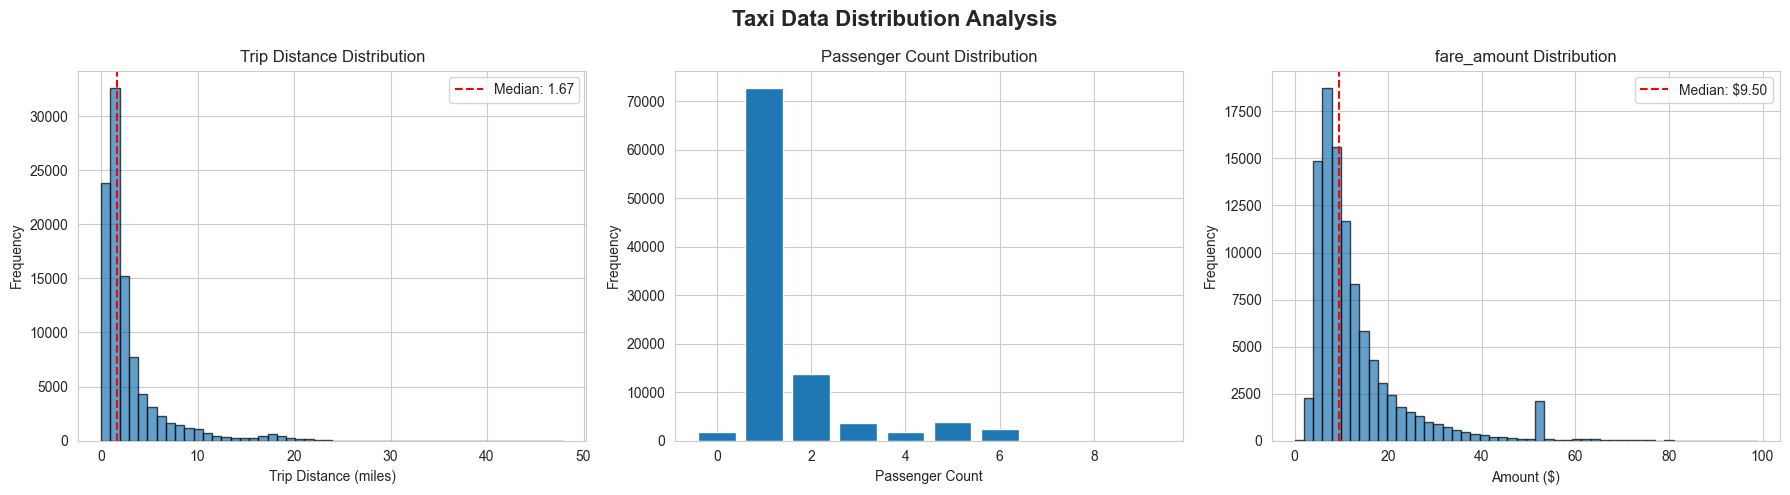

✓ Taxi distribution plots generated!

📊 Key Observations to Note:
  - Check for outliers in trip distance and fare
  - Verify reasonable passenger counts
  - Assess data quality from distributions


In [21]:
# Taxi visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print("Generating taxi distribution plots...")

# Convert to pandas if using Spark
if LAPTOP_DEPLOYMENT:
    taxi_pd = taxi_df.head(100000) if len(taxi_df) > 100000 else taxi_df  # Sample for speed
else:
    # Sample for visualization to avoid memory issues
    try:
        print("Sampling taxi data for visualization (1%)...")
        taxi_pd = taxi_df.sample(fraction=0.01, seed=42).toPandas()
        print(f"✓ Sampled {len(taxi_pd):,} taxi records")
    except Exception as e:
        print(f"⚠️  Sampling failed: {type(e).__name__}")
        print("Visualization may not be available. Try LAPTOP_DEPLOYMENT=True")
        taxi_pd = pd.DataFrame()

# Skip visualization if data is empty
if len(taxi_pd) == 0:
    print("⚠️  Cannot generate visualizations - data sampling failed")
    print("\n💡 SOLUTION: Set LAPTOP_DEPLOYMENT=True at the top of the notebook")
else:
    # Create subplots (1x3 grid for 3 taxi plots)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Taxi Data Distribution Analysis', fontsize=16, fontweight='bold')

    # 1. Trip distance distribution
    trip_dist_cols = [col for col in taxi_pd.columns if 'distance' in col.lower()]
    if trip_dist_cols:
        ax = axes[0]
        col_name = trip_dist_cols[0]
        dist_clean = taxi_pd[(taxi_pd[col_name] > 0) & (taxi_pd[col_name] < 50)]
        ax.hist(dist_clean[col_name], bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Trip Distance (miles)')
        ax.set_ylabel('Frequency')
        ax.set_title('Trip Distance Distribution')
        ax.axvline(dist_clean[col_name].median(), color='red', linestyle='--', label=f'Median: {dist_clean[col_name].median():.2f}')
        ax.legend()
    else:
        axes[0].text(0.5, 0.5, 'Trip distance\ncolumn not found', ha='center', va='center', fontsize=12)
        axes[0].axis('off')

    # 2. Passenger count distribution
    pass_cols = [col for col in taxi_pd.columns if 'passenger' in col.lower()]
    if pass_cols:
        ax = axes[1]
        col_name = pass_cols[0]
        pass_counts = taxi_pd[col_name].value_counts().sort_index().head(10)
        ax.bar(pass_counts.index, pass_counts.values)
        ax.set_xlabel('Passenger Count')
        ax.set_ylabel('Frequency')
        ax.set_title('Passenger Count Distribution')
    else:
        axes[1].text(0.5, 0.5, 'Passenger count\ncolumn not found', ha='center', va='center', fontsize=12)
        axes[1].axis('off')

    # 3. Trip amount/fare distribution
    amount_cols = [col for col in taxi_pd.columns if 'amount' in col.lower() or 'fare' in col.lower()]
    if amount_cols:
        ax = axes[2]
        col_name = amount_cols[0]
        amount_clean = taxi_pd[(taxi_pd[col_name] > 0) & (taxi_pd[col_name] < 100)]
        ax.hist(amount_clean[col_name], bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Amount ($)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col_name} Distribution')
        ax.axvline(amount_clean[col_name].median(), color='red', linestyle='--', label=f'Median: ${amount_clean[col_name].median():.2f}')
        ax.legend()
    else:
        axes[2].text(0.5, 0.5, 'Amount/fare\ncolumn not found', ha='center', va='center', fontsize=12)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("✓ Taxi distribution plots generated!")
    print("\n📊 Key Observations to Note:")
    print("  - Check for outliers in trip distance and fare")
    print("  - Verify reasonable passenger counts")
    print("  - Assess data quality from distributions")

## 5. Data Preparation: Craigslist Cars

### 5.1 Filter to NY State and 2019-2020

In [ ]:
print("Filtering Craigslist data to NY state, 2019-2020...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas operations
    ny_cars_raw = craigslist_df[craigslist_df['state'] == 'ny'].copy()
    print(f"✓ NY car listings: {len(ny_cars_raw):,}")
    
    # Convert date column
    ny_cars_raw['posting_date'] = pd.to_datetime(ny_cars_raw['posting_date'], errors='coerce')
    
    # Show date range
    print(f"\nDate range: {ny_cars_raw['posting_date'].min()} to {ny_cars_raw['posting_date'].max()}")
    
else:
    # Cloud: Spark operations
    ny_cars_raw = craigslist_df.filter(col("state") == "ny")
    print(f"✓ NY car listings: {ny_cars_raw.count():,}")
    
    print("\nDate range in dataset:")
    ny_cars_raw.select(
        min("posting_date").alias("min_date"),
        max("posting_date").alias("max_date")
    ).show()

In [ ]:
print("Cleaning and filtering to 2019-2020...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas operations
    ny_cars_cleaned = ny_cars_raw[
        ny_cars_raw['price'].notna() &
        ny_cars_raw['year'].notna() &
        ny_cars_raw['posting_date'].notna()
    ].copy()
    
    # Filter to 2019-2020
    ny_cars_cleaned = ny_cars_cleaned[
        ny_cars_cleaned['posting_date'].dt.year.isin([2019, 2020])
    ]
    
    # Convert types
    ny_cars_cleaned['price'] = pd.to_numeric(ny_cars_cleaned['price'], errors='coerce')
    ny_cars_cleaned['year'] = pd.to_numeric(ny_cars_cleaned['year'], errors='coerce').astype('Int64')
    ny_cars_cleaned['odometer'] = pd.to_numeric(ny_cars_cleaned['odometer'], errors='coerce')
    
    print(f"✓ After filtering 2019-2020: {len(ny_cars_cleaned):,} records")
    
else:
    # Cloud: Spark operations
    ny_cars_cleaned = ny_cars_raw \
        .filter(col("price").isNotNull()) \
        .filter(col("year").isNotNull()) \
        .filter(col("posting_date").isNotNull()) \
        .withColumn("posting_date", to_timestamp(col("posting_date"))) \
        .filter(year(col("posting_date")).isin([2019, 2020])) \
        .withColumn("price", col("price").cast("double")) \
        .withColumn("year", col("year").cast("int")) \
        .withColumn("odometer", col("odometer").cast("double"))
    
    print(f"✓ After filtering 2019-2020: {ny_cars_cleaned.count():,} records")

### 5.2 Calculate Statistics and Remove Outliers

In [ ]:
print("Calculating price statistics...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas statistics
    price_stats = {
        'mean_price': ny_cars_cleaned['price'].mean(),
        'std_price': ny_cars_cleaned['price'].std(),
        'min_price': ny_cars_cleaned['price'].min(),
        'max_price': ny_cars_cleaned['price'].max(),
        'p01': ny_cars_cleaned['price'].quantile(0.01),
        'p99': ny_cars_cleaned['price'].quantile(0.99)
    }
else:
    # Cloud: Spark statistics
    price_stats = ny_cars_cleaned.select(
        mean("price").alias("mean_price"),
        stddev("price").alias("std_price"),
        expr("percentile_approx(price, 0.01)").alias("p01"),
        expr("percentile_approx(price, 0.99)").alias("p99"),
        min("price").alias("min_price"),
        max("price").alias("max_price")
    ).collect()[0].asDict()

print("\n=== PRICE STATISTICS ===")
print(f"Mean: ${price_stats['mean_price']:,.2f}")
print(f"Std Dev: ${price_stats['std_price']:,.2f}")
print(f"Min: ${price_stats['min_price']:,.2f}")
print(f"Max: ${price_stats['max_price']:,.2f}")
print(f"1st percentile: ${price_stats['p01']:,.2f}")
print(f"99th percentile: ${price_stats['p99']:,.2f}")

# Define outlier thresholds
price_lower = max(500, price_stats['p01'])
price_upper = min(75000, price_stats['p99'])

print(f"\n✓ Outlier thresholds: ${price_lower:,.2f} - ${price_upper:,.2f}")

In [ ]:
print("Removing outliers...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas filtering
    outliers_mask = (ny_cars_cleaned['price'] < price_lower) | (ny_cars_cleaned['price'] > price_upper)
    outliers_removed = ny_cars_cleaned[outliers_mask]
    ny_cars = ny_cars_cleaned[~outliers_mask].copy()
    
    print(f"\n=== OUTLIER REMOVAL REPORT ===")
    print(f"Records before: {len(ny_cars_cleaned):,}")
    print(f"Outliers removed: {len(outliers_removed):,} ({len(outliers_removed)/len(ny_cars_cleaned)*100:.2f}%)")
    print(f"Records after: {len(ny_cars):,}")
    
    print("\nOutlier breakdown:")
    too_low = (outliers_removed['price'] < price_lower).sum()
    too_high = (outliers_removed['price'] > price_upper).sum()
    print(f"  Too low (< ${price_lower:,.0f}): {too_low:,}")
    print(f"  Too high (> ${price_upper:,.0f}): {too_high:,}")
    
else:
    # Cloud: Spark filtering
    outliers_removed = ny_cars_cleaned.filter(
        (col("price") < price_lower) | (col("price") > price_upper)
    )
    ny_cars = ny_cars_cleaned.filter(
        (col("price") >= price_lower) & (col("price") <= price_upper)
    )
    
    print(f"\n=== OUTLIER REMOVAL REPORT ===")
    print(f"Records before: {ny_cars_cleaned.count():,}")
    print(f"Outliers removed: {outliers_removed.count():,} ({outliers_removed.count()/ny_cars_cleaned.count()*100:.2f}%)")
    print(f"Records after: {ny_cars.count():,}")
    
    print("\nOutlier breakdown:")
    outliers_removed.select(
        count(when(col("price") < price_lower, 1)).alias("too_low"),
        count(when(col("price") > price_upper, 1)).alias("too_high")
    ).show()

### 5.3 Add Derived Columns

In [ ]:
print("Adding derived columns for dimensional analysis...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas operations
    ny_cars_final = ny_cars.copy()
    
    # Date dimensions
    ny_cars_final['date'] = ny_cars_final['posting_date'].dt.date
    ny_cars_final['year_month'] = ny_cars_final['posting_date'].dt.strftime('%Y-%m')
    ny_cars_final['year_week'] = ny_cars_final['posting_date'].dt.strftime('%Y-%U')
    
    # Vehicle age
    ny_cars_final['vehicle_age'] = ny_cars_final['posting_date'].dt.year - ny_cars_final['year']
    ny_cars_final['age_category'] = pd.cut(
        ny_cars_final['vehicle_age'],
        bins=[-np.inf, 3, 7, 12, np.inf],
        labels=['0-3 years', '4-7 years', '8-12 years', '12+ years']
    )
    
    # Clean text fields
    ny_cars_final['vehicle_type_clean'] = ny_cars_final['type'].fillna('unknown').str.lower().str.strip()
    ny_cars_final['manufacturer_clean'] = ny_cars_final['manufacturer'].fillna('unknown').str.lower().str.strip()
    ny_cars_final['region_clean'] = ny_cars_final['region'].fillna('unknown').str.lower().str.strip()
    
    print(f"✓ Final car dataset: {len(ny_cars_final):,} records")
    print("\nSample:")
    print(ny_cars_final[[
        'date', 'year_month', 'price', 'manufacturer_clean',
        'vehicle_type_clean', 'age_category', 'region_clean'
    ]].head(10))
    
else:
    # Cloud: Spark operations
    ny_cars_final = ny_cars \
        .withColumn("date", to_date(col("posting_date"))) \
        .withColumn("year_month", date_format(col("posting_date"), "yyyy-MM")) \
        .withColumn("year_week", date_format(col("posting_date"), "yyyy-ww")) \
        .withColumn("vehicle_age", year(col("posting_date")) - col("year")) \
        .withColumn(
            "age_category",
            when(col("vehicle_age") <= 3, "0-3 years")
            .when(col("vehicle_age") <= 7, "4-7 years")
            .when(col("vehicle_age") <= 12, "8-12 years")
            .otherwise("12+ years")
        ) \
        .withColumn(
            "vehicle_type_clean",
            coalesce(lower(trim(col("type"))), lit("unknown"))
        ) \
        .withColumn(
            "manufacturer_clean",
            coalesce(lower(trim(col("manufacturer"))), lit("unknown"))
        ) \
        .withColumn(
            "region_clean",
            coalesce(lower(trim(col("region"))), lit("unknown"))
        )
    
    print("✓ Final car dataset prepared")
    ny_cars_final.select(
        "date", "year_month", "price", "manufacturer_clean",
        "vehicle_type_clean", "age_category", "region_clean"
    ).show(10)

## 6. Data Preparation: NYC Taxi

### 6.1 Identify Columns and Filter 2019-2020

In [ ]:
print("Identifying datetime columns...")

if LAPTOP_DEPLOYMENT:
    taxi_columns = list(taxi_df.columns)
else:
    taxi_columns = taxi_df.columns

pickup_col = [c for c in taxi_columns if 'pickup' in c.lower() and 'datetime' in c.lower()][0]
dropoff_col = [c for c in taxi_columns if 'dropoff' in c.lower() and 'datetime' in c.lower()][0]

print(f"✓ Using columns: {pickup_col}, {dropoff_col}")

In [ ]:
print("Cleaning and filtering taxi data to 2019-2020...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas operations
    taxi_cleaned = taxi_df[taxi_df[pickup_col].notna()].copy()
    
    # Convert datetime
    taxi_cleaned['pickup_datetime'] = pd.to_datetime(taxi_cleaned[pickup_col], errors='coerce')
    taxi_cleaned['dropoff_datetime'] = pd.to_datetime(taxi_cleaned[dropoff_col], errors='coerce')
    
    # Filter to 2019-2020
    taxi_cleaned = taxi_cleaned[
        taxi_cleaned['pickup_datetime'].dt.year.isin([2019, 2020]) &
        (taxi_cleaned['pickup_datetime'] < taxi_cleaned['dropoff_datetime'])
    ]
    
    print(f"✓ Taxi records in 2019-2020: {len(taxi_cleaned):,}")
    
else:
    # Cloud: Spark operations
    taxi_cleaned = taxi_df \
        .filter(col(pickup_col).isNotNull()) \
        .withColumn("pickup_datetime", to_timestamp(col(pickup_col))) \
        .withColumn("dropoff_datetime", to_timestamp(col(dropoff_col))) \
        .filter(year(col("pickup_datetime")).isin([2019, 2020])) \
        .filter(col("pickup_datetime") < col("dropoff_datetime"))
    
    print(f"✓ Taxi records in 2019-2020: {taxi_cleaned.count():,}")

### 6.2 Remove Distance Outliers

In [ ]:
# Check for distance column
distance_col = None
for col_name in ['trip_distance', 'distance']:
    if col_name in taxi_columns:
        distance_col = col_name
        break

if distance_col:
    print(f"Removing trip distance outliers (using column: {distance_col})...")
    
    if LAPTOP_DEPLOYMENT:
        # Laptop: Pandas operations
        p99_distance = taxi_cleaned[distance_col].quantile(0.99)
        max_trip_distance = min(50, p99_distance)
        
        outliers_count = (
            (taxi_cleaned[distance_col] <= 0) | 
            (taxi_cleaned[distance_col] > max_trip_distance)
        ).sum()
        
        taxi_cleaned = taxi_cleaned[
            (taxi_cleaned[distance_col] > 0) & 
            (taxi_cleaned[distance_col] <= max_trip_distance)
        ]
        
        print(f"\n=== TAXI OUTLIER REMOVAL ===")
        print(f"Outliers removed: {outliers_count:,}")
        print(f"✓ Remaining records: {len(taxi_cleaned):,}")
        
    else:
        # Cloud: Spark operations
        taxi_distance_stats = taxi_cleaned.select(
            expr(f"percentile_approx({distance_col}, 0.99)").alias("p99_distance"),
            max(distance_col).alias("max_distance")
        ).collect()[0]
        
        max_trip_distance = min(50, taxi_distance_stats['p99_distance'])
        
        outliers_taxi = taxi_cleaned.filter(
            (col(distance_col) <= 0) | (col(distance_col) > max_trip_distance)
        )
        
        taxi_cleaned = taxi_cleaned.filter(
            (col(distance_col) > 0) & (col(distance_col) <= max_trip_distance)
        )
        
        print(f"\n=== TAXI OUTLIER REMOVAL ===")
        print(f"Outliers removed: {outliers_taxi.count():,}")
        print(f"✓ Remaining records: {taxi_cleaned.count():,}")
else:
    print("⚠ No distance column found, skipping distance outlier removal")

### 6.3 Add Time Dimensions

In [ ]:
print("Adding time dimensions to taxi data...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas operations
    taxi_final = taxi_cleaned.copy()
    
    taxi_final['pickup_date'] = taxi_final['pickup_datetime'].dt.date
    taxi_final['pickup_year_month'] = taxi_final['pickup_datetime'].dt.strftime('%Y-%m')
    taxi_final['pickup_year_week'] = taxi_final['pickup_datetime'].dt.strftime('%Y-%U')
    taxi_final['pickup_hour'] = taxi_final['pickup_datetime'].dt.hour
    taxi_final['dropoff_date'] = taxi_final['dropoff_datetime'].dt.date
    taxi_final['trip_duration_min'] = (
        (taxi_final['dropoff_datetime'] - taxi_final['pickup_datetime']).dt.total_seconds() / 60
    )
    
    print(f"✓ Taxi dataset prepared: {len(taxi_final):,} records")
    print("\nSample:")
    print(taxi_final[['pickup_date', 'pickup_year_month', 'pickup_hour', 'trip_duration_min']].head(10))
    
else:
    # Cloud: Spark operations
    taxi_final = taxi_cleaned \
        .withColumn("pickup_date", to_date(col("pickup_datetime"))) \
        .withColumn("pickup_year_month", date_format(col("pickup_datetime"), "yyyy-MM")) \
        .withColumn("pickup_year_week", date_format(col("pickup_datetime"), "yyyy-ww")) \
        .withColumn("pickup_hour", hour(col("pickup_datetime"))) \
        .withColumn("dropoff_date", to_date(col("dropoff_datetime"))) \
        .withColumn("trip_duration_min",
                    (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)
    
    print("✓ Taxi dataset prepared")
    taxi_final.select(
        "pickup_date", "pickup_year_month", "pickup_hour", "trip_duration_min"
    ).show(10)

## 7. Build Dimensional Model - Taxi Demand Facts

In [ ]:
print("Creating taxi demand aggregations...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas aggregations
    
    # Daily pickup density
    pickup_density_daily = taxi_final.groupby('pickup_date').agg({
        'pickup_datetime': 'count',
        'trip_duration_min': 'mean'
    }).rename(columns={
        'pickup_datetime': 'pickup_trip_count',
        'trip_duration_min': 'avg_trip_duration'
    }).reset_index().rename(columns={'pickup_date': 'date'})
    
    # Daily dropoff density
    dropoff_density_daily = taxi_final.groupby('dropoff_date').agg({
        'dropoff_datetime': 'count'
    }).rename(columns={
        'dropoff_datetime': 'dropoff_trip_count'
    }).reset_index().rename(columns={'dropoff_date': 'date'})
    
    # Merge
    taxi_demand_daily = pickup_density_daily.merge(
        dropoff_density_daily, on='date', how='outer'
    ).fillna(0)
    
    taxi_demand_daily['total_trip_count'] = (
        taxi_demand_daily['pickup_trip_count'] + taxi_demand_daily['dropoff_trip_count']
    )
    taxi_demand_daily['date'] = pd.to_datetime(taxi_demand_daily['date'])
    taxi_demand_daily['year_month'] = taxi_demand_daily['date'].dt.strftime('%Y-%m')
    taxi_demand_daily['year_week'] = taxi_demand_daily['date'].dt.strftime('%Y-%U')
    
    print(f"✓ Daily taxi demand records: {len(taxi_demand_daily):,}")
    print("\nSample:")
    print(taxi_demand_daily.head(10))
    
else:
    # Cloud: Spark aggregations
    pickup_density_daily = taxi_final \
        .groupBy("pickup_date") \
        .agg(
            count("*").alias("pickup_trip_count"),
            avg("trip_duration_min").alias("avg_trip_duration")
        ) \
        .withColumn("trip_type", lit("pickup"))
    
    dropoff_density_daily = taxi_final \
        .groupBy("dropoff_date") \
        .agg(
            count("*").alias("dropoff_trip_count"),
        ) \
        .withColumnRenamed("dropoff_date", "date")
    
    taxi_demand_daily = pickup_density_daily \
        .withColumnRenamed("pickup_date", "date") \
        .join(dropoff_density_daily, "date", "outer") \
        .fillna(0) \
        .withColumn("total_trip_count", col("pickup_trip_count") + col("dropoff_trip_count")) \
        .withColumn("year_month", date_format(col("date"), "yyyy-MM")) \
        .withColumn("year_week", date_format(col("date"), "yyyy-ww"))
    
    print(f"✓ Daily taxi demand records: {taxi_demand_daily.count():,}")
    taxi_demand_daily.orderBy("date").show(10)

In [ ]:
# Weekly aggregation
print("Creating weekly aggregation...")

if LAPTOP_DEPLOYMENT:
    taxi_demand_weekly = taxi_demand_daily.groupby('year_week').agg({
        'pickup_trip_count': 'sum',
        'dropoff_trip_count': 'sum',
        'total_trip_count': 'sum',
        'avg_trip_duration': 'mean'
    }).reset_index()
    
    print(f"✓ Weekly taxi demand records: {len(taxi_demand_weekly):,}")
else:
    taxi_demand_weekly = taxi_demand_daily \
        .groupBy("year_week") \
        .agg(
            sum("pickup_trip_count").alias("pickup_trip_count"),
            sum("dropoff_trip_count").alias("dropoff_trip_count"),
            sum("total_trip_count").alias("total_trip_count"),
            avg("avg_trip_duration").alias("avg_trip_duration")
        )
    
    print(f"✓ Weekly taxi demand records: {taxi_demand_weekly.count():,}")

In [ ]:
# Monthly aggregation
print("Creating monthly aggregation...")

if LAPTOP_DEPLOYMENT:
    taxi_demand_monthly = taxi_demand_daily.groupby('year_month').agg({
        'pickup_trip_count': 'sum',
        'dropoff_trip_count': 'sum',
        'total_trip_count': 'sum',
        'avg_trip_duration': 'mean',
        'date': 'count'
    }).rename(columns={'date': 'days_in_period'}).reset_index()
    
    taxi_demand_monthly['avg_daily_trips'] = (
        taxi_demand_monthly['total_trip_count'] / taxi_demand_monthly['days_in_period']
    )
    
    print(f"✓ Monthly taxi demand records: {len(taxi_demand_monthly):,}")
    print("\nSample:")
    print(taxi_demand_monthly)
else:
    taxi_demand_monthly = taxi_demand_daily \
        .groupBy("year_month") \
        .agg(
            sum("pickup_trip_count").alias("pickup_trip_count"),
            sum("dropoff_trip_count").alias("dropoff_trip_count"),
            sum("total_trip_count").alias("total_trip_count"),
            avg("avg_trip_duration").alias("avg_trip_duration"),
            count("date").alias("days_in_period")
        ) \
        .withColumn("avg_daily_trips", col("total_trip_count") / col("days_in_period"))
    
    print(f"✓ Monthly taxi demand records: {taxi_demand_monthly.count():,}")
    taxi_demand_monthly.orderBy("year_month").show()

## 8. Build Dimensional Model - Car Price Facts

In [ ]:
print("Creating car price aggregations...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas aggregations
    
    # Daily
    car_price_daily = ny_cars_final.groupby('date').agg({
        'price': ['median', 'mean', 'count', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
    })
    car_price_daily.columns = ['median_price', 'avg_price', 'listing_count', 'p25_price', 'p75_price']
    car_price_daily = car_price_daily.reset_index()
    car_price_daily['date'] = pd.to_datetime(car_price_daily['date'])
    car_price_daily['year_month'] = car_price_daily['date'].dt.strftime('%Y-%m')
    car_price_daily['year_week'] = car_price_daily['date'].dt.strftime('%Y-%U')
    
    print(f"✓ Daily car price records: {len(car_price_daily):,}")
    
    # Weekly
    car_price_weekly = ny_cars_final.groupby('year_week').agg({
        'price': ['median', 'mean', 'count']
    })
    car_price_weekly.columns = ['median_price', 'avg_price', 'listing_count']
    car_price_weekly = car_price_weekly.reset_index()
    
    print(f"✓ Weekly car price records: {len(car_price_weekly):,}")
    
    # Monthly
    car_price_monthly = ny_cars_final.groupby('year_month').agg({
        'price': ['median', 'mean', 'count', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
    })
    car_price_monthly.columns = ['median_price', 'avg_price', 'listing_count', 'p25_price', 'p75_price']
    car_price_monthly = car_price_monthly.reset_index()
    
    print(f"✓ Monthly car price records: {len(car_price_monthly):,}")
    print("\nSample:")
    print(car_price_monthly)
    
else:
    # Cloud: Spark aggregations
    
    # Daily
    car_price_daily = ny_cars_final \
        .groupBy("date") \
        .agg(
            expr("percentile_approx(price, 0.5)").alias("median_price"),
            avg("price").alias("avg_price"),
            count("*").alias("listing_count"),
            expr("percentile_approx(price, 0.25)").alias("p25_price"),
            expr("percentile_approx(price, 0.75)").alias("p75_price")
        ) \
        .withColumn("year_month", date_format(col("date"), "yyyy-MM")) \
        .withColumn("year_week", date_format(col("date"), "yyyy-ww"))
    
    print(f"✓ Daily car price records: {car_price_daily.count():,}")
    
    # Weekly
    car_price_weekly = ny_cars_final \
        .groupBy("year_week") \
        .agg(
            expr("percentile_approx(price, 0.5)").alias("median_price"),
            avg("price").alias("avg_price"),
            count("*").alias("listing_count")
        )
    
    print(f"✓ Weekly car price records: {car_price_weekly.count():,}")
    
    # Monthly
    car_price_monthly = ny_cars_final \
        .groupBy("year_month") \
        .agg(
            expr("percentile_approx(price, 0.5)").alias("median_price"),
            avg("price").alias("avg_price"),
            count("*").alias("listing_count"),
            expr("percentile_approx(price, 0.25)").alias("p25_price"),
            expr("percentile_approx(price, 0.75)").alias("p75_price")
        )
    
    print(f"✓ Monthly car price records: {car_price_monthly.count():,}")
    car_price_monthly.orderBy("year_month").show()

In [ ]:
# Car price by vehicle type (monthly)
print("Creating price by vehicle type...")

if LAPTOP_DEPLOYMENT:
    car_price_by_type_monthly = ny_cars_final.groupby(['year_month', 'vehicle_type_clean']).agg({
        'price': ['median', 'count']
    })
    car_price_by_type_monthly.columns = ['median_price', 'listing_count']
    car_price_by_type_monthly = car_price_by_type_monthly.reset_index()
    car_price_by_type_monthly = car_price_by_type_monthly[
        car_price_by_type_monthly['listing_count'] >= 10
    ]
    
    print(f"✓ Car price by type (monthly): {len(car_price_by_type_monthly):,}")
else:
    car_price_by_type_monthly = ny_cars_final \
        .groupBy("year_month", "vehicle_type_clean") \
        .agg(
            expr("percentile_approx(price, 0.5)").alias("median_price"),
            count("*").alias("listing_count")
        ) \
        .filter(col("listing_count") >= 10)
    
    print(f"✓ Car price by type (monthly): {car_price_by_type_monthly.count():,}")

In [ ]:
# Car price by age category (monthly)
print("Creating price by age category...")

if LAPTOP_DEPLOYMENT:
    car_price_by_age_monthly = ny_cars_final.groupby(['year_month', 'age_category']).agg({
        'price': ['median', 'count']
    })
    car_price_by_age_monthly.columns = ['median_price', 'listing_count']
    car_price_by_age_monthly = car_price_by_age_monthly.reset_index()
    car_price_by_age_monthly = car_price_by_age_monthly[
        car_price_by_age_monthly['listing_count'] >= 10
    ]
    
    print(f"✓ Car price by age (monthly): {len(car_price_by_age_monthly):,}")
else:
    car_price_by_age_monthly = ny_cars_final \
        .groupBy("year_month", "age_category") \
        .agg(
            expr("percentile_approx(price, 0.5)").alias("median_price"),
            count("*").alias("listing_count")
        ) \
        .filter(col("listing_count") >= 10)
    
    print(f"✓ Car price by age (monthly): {car_price_by_age_monthly.count():,}")

## 9. Combine Fact Tables (Join)

In [ ]:
print("Joining taxi demand and car price facts...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Pandas merge
    
    # Daily
    combined_daily = taxi_demand_daily.merge(
        car_price_daily[['date', 'median_price', 'avg_price', 'listing_count', 'p25_price', 'p75_price']],
        on='date',
        how='inner'
    ).sort_values('date')
    
    print(f"✓ Combined daily records: {len(combined_daily):,}")
    
    # Weekly
    combined_weekly = taxi_demand_weekly.merge(
        car_price_weekly,
        on='year_week',
        how='inner'
    ).sort_values('year_week')
    
    print(f"✓ Combined weekly records: {len(combined_weekly):,}")
    
    # Monthly
    combined_monthly = taxi_demand_monthly.merge(
        car_price_monthly,
        on='year_month',
        how='inner'
    )
    combined_monthly = combined_monthly.rename(columns={
        'pickup_trip_count': 'monthly_pickups',
        'dropoff_trip_count': 'monthly_dropoffs',
        'total_trip_count': 'monthly_total_trips'
    }).sort_values('year_month')
    
    print(f"✓ Combined monthly records: {len(combined_monthly):,}")
    print("\nMonthly combined data:")
    print(combined_monthly)
    
else:
    # Cloud: Spark join
    
    # Daily
    combined_daily = taxi_demand_daily \
        .join(car_price_daily, "date", "inner") \
        .select(
            "date",
            "year_month",
            "year_week",
            "pickup_trip_count",
            "dropoff_trip_count",
            "total_trip_count",
            "avg_trip_duration",
            "median_price",
            "avg_price",
            "listing_count",
            "p25_price",
            "p75_price"
        ) \
        .orderBy("date")
    
    print(f"✓ Combined daily records: {combined_daily.count():,}")
    
    # Weekly
    combined_weekly = taxi_demand_weekly \
        .join(car_price_weekly, "year_week", "inner") \
        .orderBy("year_week")
    
    print(f"✓ Combined weekly records: {combined_weekly.count():,}")
    
    # Monthly
    combined_monthly = taxi_demand_monthly \
        .join(car_price_monthly, "year_month", "inner") \
        .select(
            "year_month",
            col("pickup_trip_count").alias("monthly_pickups"),
            col("dropoff_trip_count").alias("monthly_dropoffs"),
            col("total_trip_count").alias("monthly_total_trips"),
            "avg_daily_trips",
            "avg_trip_duration",
            "median_price",
            "avg_price",
            "listing_count",
            "p25_price",
            "p75_price"
        ) \
        .orderBy("year_month")
    
    print(f"✓ Combined monthly records: {combined_monthly.count():,}")
    combined_monthly.show()

## 10. Convert to Pandas for Analysis & Visualization

In [ ]:
print("Converting to Pandas for correlation analysis and visualization...")

if LAPTOP_DEPLOYMENT:
    # Already in Pandas, just assign
    combined_daily_pd = combined_daily
    combined_weekly_pd = combined_weekly
    combined_monthly_pd = combined_monthly
    price_by_type_pd = car_price_by_type_monthly
    price_by_age_pd = car_price_by_age_monthly
else:
    # Convert from Spark to Pandas
    combined_daily_pd = combined_daily.toPandas()
    combined_weekly_pd = combined_weekly.toPandas()
    combined_monthly_pd = combined_monthly.toPandas()
    price_by_type_pd = car_price_by_type_monthly.toPandas()
    price_by_age_pd = car_price_by_age_monthly.toPandas()

print("✓ Data ready for analysis")

## 11. Correlation Analysis

In [ ]:
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

print("\n1. Daily Granularity:")
print(f"   Pickup trips vs Median price: {combined_daily_pd['pickup_trip_count'].corr(combined_daily_pd['median_price']):.4f}")
print(f"   Dropoff trips vs Median price: {combined_daily_pd['dropoff_trip_count'].corr(combined_daily_pd['median_price']):.4f}")
print(f"   Total trips vs Median price: {combined_daily_pd['total_trip_count'].corr(combined_daily_pd['median_price']):.4f}")

print("\n2. Weekly Granularity:")
print(f"   Pickup trips vs Median price: {combined_weekly_pd['pickup_trip_count'].corr(combined_weekly_pd['median_price']):.4f}")
print(f"   Dropoff trips vs Median price: {combined_weekly_pd['dropoff_trip_count'].corr(combined_weekly_pd['median_price']):.4f}")
print(f"   Total trips vs Median price: {combined_weekly_pd['total_trip_count'].corr(combined_weekly_pd['median_price']):.4f}")

print("\n3. Monthly Granularity:")
print(f"   Monthly pickups vs Median price: {combined_monthly_pd['monthly_pickups'].corr(combined_monthly_pd['median_price']):.4f}")
print(f"   Monthly dropoffs vs Median price: {combined_monthly_pd['monthly_dropoffs'].corr(combined_monthly_pd['median_price']):.4f}")
print(f"   Monthly total trips vs Median price: {combined_monthly_pd['monthly_total_trips'].corr(combined_monthly_pd['median_price']):.4f}")
print(f"   Avg daily trips vs Median price: {combined_monthly_pd['avg_daily_trips'].corr(combined_monthly_pd['median_price']):.4f}")

In [ ]:
# Lagged correlation analysis
combined_monthly_pd_sorted = combined_monthly_pd.sort_values('year_month').copy()

print("\n=== LAGGED CORRELATION ANALYSIS ===")
print("(Does taxi demand predict future car prices?)\n")

for lag in [1, 2, 3]:
    combined_monthly_pd_sorted[f'median_price_lag_{lag}'] = combined_monthly_pd_sorted['median_price'].shift(lag)
    corr = combined_monthly_pd_sorted['monthly_total_trips'].corr(
        combined_monthly_pd_sorted[f'median_price_lag_{lag}']
    )
    print(f"Lag {lag} month: Trips vs Price: {corr:.4f}")

print("\n(Does car price predict future taxi demand?)\n")
for lag in [1, 2, 3]:
    combined_monthly_pd_sorted[f'trips_lag_{lag}'] = combined_monthly_pd_sorted['monthly_total_trips'].shift(lag)
    corr = combined_monthly_pd_sorted['median_price'].corr(
        combined_monthly_pd_sorted[f'trips_lag_{lag}']
    )
    print(f"Lag {lag} month: Price vs Trips: {corr:.4f}")

## 12. Summary Statistics

In [ ]:
print("\n" + "=" * 60)
print("DATASET SUMMARY")
print("=" * 60)

print(f"\nTime period: 2019-2020")

if LAPTOP_DEPLOYMENT:
    print(f"Taxi trips analyzed: {len(taxi_final):,}")
    print(f"NY car listings analyzed: {len(ny_cars_final):,}")
else:
    print(f"Taxi trips analyzed: {taxi_final.count():,}")
    print(f"NY car listings analyzed: {ny_cars_final.count():,}")

print(f"\nDaily observations: {len(combined_daily_pd):,}")
print(f"Weekly observations: {len(combined_weekly_pd):,}")
print(f"Monthly observations: {len(combined_monthly_pd):,}")

print("\n=== KEY INSIGHTS ===")
print(f"Average daily taxi trips: {combined_monthly_pd['avg_daily_trips'].mean():,.0f}")
print(f"Average median car price: ${combined_monthly_pd['median_price'].mean():,.2f}")
print(f"Price range: ${combined_monthly_pd['median_price'].min():,.2f} - ${combined_monthly_pd['median_price'].max():,.2f}")
print(f"Trip volume range: {combined_monthly_pd['monthly_total_trips'].min():,.0f} - {combined_monthly_pd['monthly_total_trips'].max():,.0f}")

## 13. Export Combined Datasets

In [ ]:
print("Saving combined datasets...")

if LAPTOP_DEPLOYMENT:
    # Laptop: Save as parquet using Pandas
    combined_daily_pd.to_parquet('data/combined_daily.parquet', index=False)
    combined_weekly_pd.to_parquet('data/combined_weekly.parquet', index=False)
    combined_monthly_pd.to_parquet('data/combined_monthly.parquet', index=False)
    price_by_type_pd.to_parquet('data/price_by_type_monthly.parquet', index=False)
    price_by_age_pd.to_parquet('data/price_by_age_monthly.parquet', index=False)
else:
    # Cloud: Save using Spark
    combined_daily.write.mode('overwrite').parquet('data/combined_daily.parquet')
    combined_weekly.write.mode('overwrite').parquet('data/combined_weekly.parquet')
    combined_monthly.write.mode('overwrite').parquet('data/combined_monthly.parquet')
    car_price_by_type_monthly.write.mode('overwrite').parquet('data/price_by_type_monthly.parquet')
    car_price_by_age_monthly.write.mode('overwrite').parquet('data/price_by_age_monthly.parquet')

print("✓ Combined datasets saved to parquet files")

## 14. Visualizations

The visualization code below works the same regardless of deployment mode (since we've converted to Pandas).

### Graph 1: Time Series Overlay

In [ ]:
# Prepare data
combined_monthly_pd['year_month_dt'] = pd.to_datetime(combined_monthly_pd['year_month'])

# Create figure with secondary y-axis
fig = go.Figure()

# Add taxi trips trace
fig.add_trace(go.Scatter(
    x=combined_monthly_pd['year_month_dt'],
    y=combined_monthly_pd['monthly_total_trips'],
    name='Total Taxi Trips',
    line=dict(color='blue', width=2),
    yaxis='y'
))

# Add car price trace
fig.add_trace(go.Scatter(
    x=combined_monthly_pd['year_month_dt'],
    y=combined_monthly_pd['median_price'],
    name='Median Car Price',
    line=dict(color='red', width=2),
    yaxis='y2'
))

# Update layout
fig.update_layout(
    title='NYC Taxi Demand vs Used Car Prices Over Time (2019-2020)',
    xaxis=dict(title='Month'),
    yaxis=dict(
        title='Total Taxi Trips',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue')
    ),
    yaxis2=dict(
        title='Median Car Price ($)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    hovermode='x unified',
    height=500
)

fig.show()

print("\nGraph 1: If hypothesis is true, you should see the two lines moving in similar patterns.")

### Graph 2: Scatter Plot with Trend Line

In [ ]:
# Create scatter plot
fig = px.scatter(
    combined_monthly_pd,
    x='monthly_total_trips',
    y='median_price',
    color='year_month_dt',
    trendline='ols',
    labels={
        'monthly_total_trips': 'Total Monthly Taxi Trips',
        'median_price': 'Median Car Price ($)',
        'year_month_dt': 'Month'
    },
    title='Correlation: Taxi Trip Volume vs Car Prices',
    hover_data=['year_month']
)

fig.update_layout(height=500)
fig.show()

corr_val = combined_monthly_pd['monthly_total_trips'].corr(combined_monthly_pd['median_price'])
print(f"\nGraph 2: Correlation coefficient = {corr_val:.4f}")
print("If hypothesis is true, expect positive correlation (upward trend line).")

### Graph 3: Correlation Heatmap

In [ ]:
# Select numeric columns for correlation
corr_cols = [
    'monthly_pickups', 'monthly_dropoffs', 'monthly_total_trips',
    'avg_daily_trips', 'avg_trip_duration', 'median_price', 'avg_price'
]

corr_matrix = combined_monthly_pd[corr_cols].corr()

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu',
    zmid=0,
    text=corr_matrix.values,
    texttemplate='%{text:.3f}',
    textfont={"size": 10}
))

fig.update_layout(
    title='Correlation Matrix: All Variables',
    height=600,
    xaxis={'side': 'bottom'}
)

fig.show()

print("\nGraph 3: Look for strong correlations (close to +1 or -1) between trip metrics and price.")

### Graph 4: Lagged Correlation Plot

In [ ]:
# Calculate lagged correlations
lags = list(range(0, 6))
trips_to_price_corr = []
price_to_trips_corr = []

combined_monthly_sorted = combined_monthly_pd.sort_values('year_month')

for lag in lags:
    if lag == 0:
        trips_to_price_corr.append(
            combined_monthly_sorted['monthly_total_trips'].corr(combined_monthly_sorted['median_price'])
        )
        price_to_trips_corr.append(
            combined_monthly_sorted['median_price'].corr(combined_monthly_sorted['monthly_total_trips'])
        )
    else:
        trips_to_price_corr.append(
            combined_monthly_sorted['monthly_total_trips'].iloc[:-lag].corr(
                combined_monthly_sorted['median_price'].iloc[lag:]
            )
        )
        price_to_trips_corr.append(
            combined_monthly_sorted['median_price'].iloc[:-lag].corr(
                combined_monthly_sorted['monthly_total_trips'].iloc[lag:]
            )
        )

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=lags,
    y=trips_to_price_corr,
    mode='lines+markers',
    name='Trips → Price (trips lead)',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=lags,
    y=price_to_trips_corr,
    mode='lines+markers',
    name='Price → Trips (price leads)',
    line=dict(color='red', width=2)
))

fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.update_layout(
    title='Lagged Correlation: Does One Variable Predict the Other?',
    xaxis_title='Lag (months)',
    yaxis_title='Correlation Coefficient',
    height=500
)

fig.show()

print("\nGraph 4: If one line peaks at lag > 0, that variable predicts the other.")

### Graph 5: Vehicle Type & Age Breakdown

In [ ]:
# Vehicle type trends
top_types = price_by_type_pd.groupby('vehicle_type_clean')['listing_count'].sum().nlargest(6).index
price_by_type_filtered = price_by_type_pd[price_by_type_pd['vehicle_type_clean'].isin(top_types)]

fig = px.line(
    price_by_type_filtered,
    x='year_month',
    y='median_price',
    color='vehicle_type_clean',
    title='Median Car Price Over Time by Vehicle Type',
    labels={'median_price': 'Median Price ($)', 'year_month': 'Month'},
    height=500
)

fig.update_xaxes(tickangle=45)
fig.show()

# Vehicle age trends
fig = px.line(
    price_by_age_pd,
    x='year_month',
    y='median_price',
    color='age_category',
    title='Median Car Price Over Time by Vehicle Age',
    labels={'median_price': 'Median Price ($)', 'year_month': 'Month'},
    height=500
)

fig.update_xaxes(tickangle=45)
fig.show()

## 15. Analysis Complete

In [ ]:
print("\n" + "="*80)
print(f"  ANALYSIS COMPLETE ({' LAPTOP MODE' if LAPTOP_DEPLOYMENT else 'CLOUD MODE'})")
print("="*80)
print("\nNext steps:")
print("1. Review all graphs above")
print("2. Look for consistent patterns across multiple visualizations")
print("3. Consider alternative explanations for any correlations found")
print("4. Focus on pre-COVID data (2019) for cleaner signal")
print("5. Be aware of geographic mismatch (NYC taxi vs NY state cars)")
print("\n⚠️  Remember: Correlation ≠ Causation")
print("\n✓ Output files saved to data/ directory")